In [1]:
#!pip3 install -U keras==2.3.1
!pip install -q -U tensorflow_addons

#!apt-get -y install libgeos-3.5.0
#!apt-get -y install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip     #basemap

#!pip install pyproj==1.9.6   #posible arreglo

!pip install adabelief-tf==0.2.0

#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
#Setup Gdrive file download extention 
#!conda install -y gdown
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 61.2 MB/s eta 0:00:0000:0100:01
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77052 sha256=75675314e47b976c29ef8717de4d59573642e51a5b7873681777b1607a1081ea
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Att

In [ ]:

keras.__version__

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Reshape
from tensorflow.keras.layers import Flatten, BatchNormalization, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model
#from tensorflow.keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

import os



X_train = np.load("../input/surfacetemp/surf_temp.npy", allow_pickle=True)

In [3]:
from scipy import stats


X_train = X_train.reshape((X_train.shape[0], 73, 144, 1)).astype('float32')

#rango de temperaturas
minimo = np.min(X_train)
maximo = np.max(X_train)
media = np.mean(X_train)
desv  = np.std(X_train)
#moda = stats.mode(X_train)

X_train = (X_train - media)/(np.abs(X_train - media)).max()

#normalizacion (0,1)
#X_train = ((X_train - minimo)/(maximo - minimo)) 

#normalizacion (1,-1)
#X_train = 2*((X_train - minimo)/(maximo - minimo)) - 1

#normalizacion (0.5,-0.5)
#X_train = ((X_train - minimo)/(maximo - minimo)) - 0.5

#normalizacion zscore
#X_train = (X_train - media)/(desv)

#centrar los datos
#X_train = (X_train - media)

#centrar y normalizacion (1,0)
#X_train = (X_train - media)
#minimo = np.min(X_train)
#maximo = np.max(X_train)
#X_train = (255*(X_train - minimo)/(maximo - minimo)) 

In [4]:
minimo = np.min(X_train)
maximo = np.max(X_train)
val_max = maximo - minimo
print(minimo)
print(maximo)
print(val_max)

#print(media)
#print(desv)


-1.0
0.44481748
1.4448175


In [5]:
############## 1k MODELO MODIFICACIONES DEL MODELO ANTERIOR #################

from tensorflow.keras.layers import Input, LSTM, RepeatVector, ConvLSTM2D, Lambda, LeakyReLU
import tensorflow_addons as tfa
from tensorflow_addons.layers import GELU
#from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Add
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers.experimental.preprocessing import Resizing

input_img = Input(shape=(73, 144, 1))
LF = (3,3)    
x = Conv2D(64, kernel_size=LF,   activation=GELU(approximate=False))(input_img)   #70 140  

##################### BLOQUES RESIDUALES #########################

LF = (3,3)
x_res1 = Conv2D(64, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res1])

x_res2 = Conv2D(64, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)

x = Add()([x, x_res2])

x_res3 = Conv2D(64, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res3])

############################################################################

x = Conv2D(32, kernel_size=LF,   strides=2, activation=GELU(approximate=False))(x) #downsampling

##################### BLOQUES RESIDUALES #########################

LF = (3,3)
x_res1 = Conv2D(32, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res1])

x_res2 = Conv2D(32, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)

x = Add()([x, x_res2])

x_res3 = Conv2D(32, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res3])

############################################################################

x = Conv2D(16, kernel_size=LF,   padding= "same", activation=GELU(approximate=False))(x) #35x70

#shortcut 1
x_short1 = Conv2D(16, kernel_size=LF, padding= "same", activation=GELU(approximate=False))(input_img)
x_short1 = Resizing(35, 70, interpolation="mitchellcubic", crop_to_aspect_ratio=True)(x_short1)  

#bloque de adicion
x = Add()([x, x_short1])    #35x70


#downsampling usando la capa resize y dejando el tamaño en 32x32=1024
x = Resizing(32, 32, interpolation="mitchellcubic")(x) 


##################### BLOQUES RESIDUALES #########################

LF = (3,3)
x_res1 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res1])

x_res2 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)

x = Add()([x, x_res2])

x_res3 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res3])

############################################################################


#shortcut 2  
x_short2 = Conv2D(16, kernel_size=LF, padding= "same", activation=GELU(approximate=False))(input_img)
x_short2 = Resizing(32, 32, interpolation="mitchellcubic")(x_short2)  


x = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 


#bloque de adicion
x = Add()([x, x_short2])

##################### BLOQUES RESIDUALES #########################

LF = (3,3)
x_res1 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res1])

x_res2 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)

x = Add()([x, x_res2])

x_res3 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x) 

x = Add()([x, x_res3])

############################################################################

#encoded = Dense(1,  activation='linear')(x)   #cambio  32x32x1
encoded = Conv2D(1, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)   #32x32x1
            ############## 1k compresion #################

encoder = Model(input_img, encoded)

###################################################################################################
###################################################################################################
###################################################################################################

decoder_input = Input(shape=(32, 32, 1))

#skip upsampling
up = Conv2DTranspose(16, kernel_size=LF,  strides=2, activation=GELU(approximate=False), padding= "same")(decoder_input)  #transpose en vez de convolucion normal
up = Resizing(73, 144, interpolation="lanczos3")(up)                #lanczos3 posiblemente mejor para upsampling
             

LF=(3,3)
#inicio deco
#upsamplig con capa resize de 32x32 a tamaño 35x70 haciendo coincidir "simetricamente" con la capa encoder
x = Resizing(35, 70, interpolation="lanczos3")(decoder_input)                #lanczos3 posiblemente mejor para upsampling
x = Conv2DTranspose(64, kernel_size=LF,  activation=GELU(approximate=False), padding= "same")(x) #35x70
 
x = Conv2DTranspose(32, kernel_size=LF,  strides=2, activation=GELU(approximate=False), padding= "same")(x)  #70x140
x = Conv2DTranspose(16, kernel_size=LF,  activation=GELU(approximate=False))(x)


#x = Conv2DTranspose(4, activation=GELU(approximate=False),     kernel_size=LF)(x)          #aumento del tamaño mas adelante en el deco
x = Conv2DTranspose(1, kernel_size=LF,   activation=GELU(approximate=False))(x)  #74x144



xr= Lambda( lambda x: x[:,0:73,0:144,:] )(x)
#out1 = Dense(1,  activation='linear')(x)
out1 = Conv2D(1, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(xr)


xr = Add()([out1, up])   



##################### BLOQUES RESIDUALES #########################

LF = (3,3)
x_res1 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(xr)

x = Add()([xr, x_res1])

x_res2 = Conv2D(16, kernel_size=LF, padding= "same",  activation=GELU(approximate=False))(x)          # cambio tamñao de los filtros 

x = Add()([x, x_res2])

x_res3 = Conv2D(16, kernel_size=LF,  padding= "same", activation=GELU(approximate=False))(x)

x = Add()([x, x_res3])

############################################################################


LF=(3,3)
x = Conv2D(4, padding='same', activation=GELU(approximate=False), kernel_size=LF)(x)

#decoded = Dense(1,  activation='linear')(x) 
decoded = Conv2D(1, activation='linear', kernel_size=LF, padding='same')(x)

decoder = Model(decoder_input, decoded)
prueba = decoder(encoded)   # pasar al decoder la salida del encoder y luego generar el modelo completo a partir de esto

autoencoder = Model(inputs=input_img, outputs=[prueba])
autoencoder.summary()
#encoder.summary()
#decoder.summary()
#plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
#plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73, 144, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 71, 142, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 71, 142, 64)  36928       conv2d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 71, 142, 64)  0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]             

In [6]:
################ REANUDAR EL ENTRENAMIENTO DONDE SE DEJO #########################
from tensorflow.keras.models import load_model
from adabelief_tf import AdaBeliefOptimizer

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#cargamos el modelo completo para aprovechar el estado del optimizador
#autoencoder_optimizador = load_model("../input/1kmodeloautoencoder100/1k_resiDeco_resize_100.h5", custom_objects={'coeff_determination': coeff_determination, 'AdaBeliefOptimizer': AdaBeliefOptimizer, 'LeakyReLU': LeakyReLU})

#añadimos los pesos al encoder y autoencoder
autoencoder.load_weights('/kaggle/input/pesosdatasetsurfadabrmse/pesos_surf_LKadab_rmse_600.h5')
#encoder.load_weights('../input/1kpesosenconorm500/pesosEnco_norm_1kresDeco_500.h5')

#compilamos el estado del optimizador
#autoencoder.compile(loss=autoencoder_optimizador.loss, optimizer=autoencoder_optimizador.optimizer, metrics=[coeff_determination])

#reanudamos el entrenamiento donde lo dejamos
#Hist=autoencoder.fit(X_train, X_train, batch_size=32, validation_split=0.2, epochs=400, verbose=1)


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
from adabelief_tf import AdaBeliefOptimizer


def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
    
def dct_2d(
        feature_map,
        norm=None # can also be 'ortho'
):
    X1 = tf.signal.dct(feature_map, type=2, norm=norm)
    X1_t = tf.transpose(X1, perm=[0, 1, 3, 2])
    X2 = tf.signal.dct(X1_t, type=2, norm=norm)
    X2_t = tf.transpose(X2, perm=[0, 1, 3, 2])
    return X2_t
    
def custom_dct(y_true, y_pred):
    true_dct = dct_2d(y_true)
    pred_dct = dct_2d(y_pred)
    #dct_loss = (K.mean(K.square(pred_dct - true_dct)))   
    rmse = K.sqrt(K.mean(K.square(pred_dct - true_dct)))
    return rmse
    

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, val_max, filter_sigma=9 , filter_size=11))   #solo valores de pixel positivos?

def custom(y_true, y_pred):
    a = 0.8
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, val_max, filter_sigma=9 , filter_size=11))
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true))) 
    return a*ssim + (1-a)*rmse
    
#power_factors = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)  #default
power_factors = (0.0448)  #single scale??

#def SSIMLoss(y_true, y_pred):
 #   return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, val_max, power_factors))   #solo valores de pixel positivos?
    
def custom_MS_SSIMLoss(y_true, y_pred):
    a = 0.8
    ms_ssim9 = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, val_max, power_factors, filter_sigma=9 , filter_size=11))
    ms_ssim6 = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, val_max, power_factors, filter_sigma=6 , filter_size=11))
    ms_ssim3 = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, val_max, power_factors, filter_sigma=3 , filter_size=11))
    l1 = (K.mean(K.abs(y_pred - y_true))) 
    #return a*ms_ssim + (1-a)*l1
    return 0.2*l1 + ms_ssim9*0.4 + ms_ssim6*0.2 + ms_ssim3*0.2

def custom_SSIMLoss(y_true, y_pred):
    a = 0.8
    ssim9 = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, val_max, filter_sigma=9 , filter_size=11))
    ssim6 = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, val_max, filter_sigma=6 , filter_size=11))
    ssim3 = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, val_max, filter_sigma=3 , filter_size=11))
    l1 = (K.mean(K.abs(y_pred - y_true))) 
    #return a*ms_ssim + (1-a)*l1
    return 0.2*l1 + ssim9*0.4 + ssim6*0.2 + ssim3*0.2


    
def scale_fn(x):               #funcion trinagular decayendo
    return 1/(2.**(x-1))    


steps_per_epoch = 659
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
    maximal_learning_rate=1e-3,
    scale_fn=scale_fn,  #lambda x: 1/(2.**(x-1)),   
    step_size= 2*steps_per_epoch)   # en teoria 2*steps_per_epoch es 1 ciclo ---- NUM_CLR_CYCLES = NUM_EPOCHS / STEP_SIZE / 2

tri = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate = 1e-5,
    maximal_learning_rate = 1e-3,
    step_size = 2*steps_per_epoch)


#optimizer = tfa.optimizers.RectifiedAdam(learning_rate=1e-3, total_steps=659, weight_decay=1e-4, epsilon=1e-7, warmup_proportion=0.1, min_lr=1e-5)
#optimizer = Adam(learning_rate=1e-3)
optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-16, rectify=False)          #cambio epsilon
#optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
optimizer = tfa.optimizers.Lookahead(optimizer)  
autoencoder.compile(loss=[custom_dct], optimizer=optimizer,metrics=[coeff_determination])
autoencoder.compile(loss=[custom_dct], optimizer=optimizer,metrics=[coeff_determination])

#entrenamiento a partir de pesos
#autoencoder = load_model("../input/2kultimoresize500/2kultimo_resize_500.h5", custom_objects={'coeff_determination': coeff_determination, 'AdaBeliefOptimizer': AdaBeliefOptimizer, 'LeakyReLU': LeakyReLU})
#encoder = load_model("../input/encoder2kultimoresize500/encoder_2kultimo_resize_500.h5", custom_objects={'coeff_determination': coeff_determination, 'AdaBeliefOptimizer': AdaBeliefOptimizer, 'LeakyReLU': LeakyReLU})



#solucion error al cargar modelo, introducir el error y el estado del optimizador
#symbolic_weights = getattr(autoencoder.optimizer, 'weights')
#weight_values = K.batch_get_value(symbolic_weights)
#autoencoder.compile(loss=autoencoder.loss, optimizer=autoencoder.optimizer, metrics=[coeff_determination])
####################
from keras.callbacks import History 
history = History()
Hist=autoencoder.fit(X_train, X_train, batch_size=32, validation_split=0.2, epochs=378, verbose=1, callbacks=[history])        


In [ ]:
print(history.history['loss'])
print(history.history['val_loss'])

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
error_train = history.history['loss']
error_test = history.history['val_loss']
np.save('./error_train_surf_LKadab_custom_447', error_train)
np.save('./error_test_surf_LKadab_custom_447', error_test)

In [ ]:
#autoencoder.save("./huber_menos1kDeco_45.h5") 
#encoder.save("./huber_menos1kEnco_45.h5")
#encoder.save_weights('pesosEnco_huber_menos1kDeco_45.h5')  
autoencoder.save_weights('pesos_surf_LKadab_custom_447.h5') 
#model.load_weights('my_model_weights.h5')
#model.set_weights(weights)  # Establece el estado del modelo.

In [7]:
X_test_21 = np.load("../input/datossurf2021/surf_2021.npy", allow_pickle=True)
X_test_21 = X_test_21.reshape((X_test_21.shape[0],73, 144, 1)).astype('float32')

                    
# usar media del conjunto de entrenamiento
X_test_21 = (X_test_21 - media)/(np.abs(X_test_21 - media)).max()



In [8]:
#imagenes codificadas
encoded_imgs = encoder.predict(X_test_21)
encoded_imgs = encoded_imgs.astype('float16')
np.save('./img_cod', encoded_imgs)

In [9]:
#imagenes decodificadas
#decoded_imgs = autoencoder.predict(X_test_21)
decoded_imgs = decoder.predict(encoded_imgs)

#calculo del error
th = 0.004
errores = (X_test_21 - decoded_imgs)/th    
#errores = (X_test_21 - decoded_imgs)/th/decoded_imgs
errores = np.round(errores).astype('int16')
np.save('./errores', errores)


In [ ]:
vector = errores[np.abs(errores)>4]
vector = vector.astype('int16')
np.save('./vector', vector)

In [ ]:
errores_2 = errores.copy()
errores_2[np.abs(errores)>4] = 5
errores_2 = errores_2.astype('int8')
np.save('./errores_2', errores_2)

In [ ]:
np.sum(errores==0)

In [ ]:
##### PRUEBA ####
#imagenes decodificadas
#decoded_imgs = autoencoder.predict(X_test_21)
decoded_imgs = decoder.predict(encoded_imgs)

#calculo del error
th = 0.04
errores = (X_test_21 - decoded_imgs)/th    
#errores = (X_test_21 - decoded_imgs)/th/decoded_imgs
errores = np.round(errores, decimals=1).astype('float16')
np.save('./errores', errores)

In [10]:
#r2 minimo igual a 0,9999800001

def r2(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

suma = errores*th + decoded_imgs                      
#suma = errores*th*decoded_imgs + decoded_imgs

r2(X_test_21, suma)   # calcular el error sin normalizar entre X_test21 y suma

########### resultados con error caracterizado como errores = (X_test_21 - decoded_imgs)/th   
# resultado de la ejecucion con el modelo 1k actual, th=0.002, igual a 
# resultado de la ejecucion con el modelo 1k actual, th=0.004, igual a 

########## resultados con error caracterizado como errores = (X_test_21 - decoded_imgs)/th/decoded_imgs
# resultado de la ejecucion con el modelo 1k actual, th=0.004, igual a 
# resultado de la ejecucion con el modelo 1k actual, th=0.01,  igual a 

0.9999806058322506

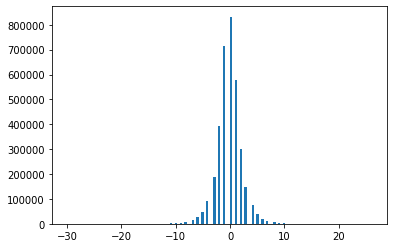

In [11]:
import matplotlib.pyplot as plt

#error_suma = X_test_21 - suma

error_suma= errores.flatten()

num_bins = 128
plt.hist(error_suma, bins=np.linspace(np.min(error_suma), np.max(error_suma), num=num_bins)) 
plt.show()

In [ ]:
error_suma.mean()

<a href="./errores.npy"> Download errores </a>
<a href="./img_cod.npy"> Download img_cod </a>

In [ ]:
#visualizacion de la decodificacion

X_train = X_train.reshape((X_train.shape[0], 73, 144, 1))
decoded_imgs = decoded_imgs.reshape((decoded_imgs.shape[0], 73, 144, 1))



In [13]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.7/925.7 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 71.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 25.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
te

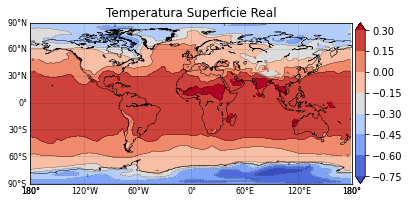

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from numpy import float32



lat = np.arange(90,-92.5,-2.5)
lon = np.arange(0,360,2.5)

a = X_test_21[75].reshape(73, 144)

# make some plot 
#print('Ploting...')
#plt.figure() #setting the figure size

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)      
#This like sets the lat lon of the plot. Projection cylinder. 

map.drawcoastlines(linewidth=.5)  #draws coastline 

parallels = np.arange(-90,91,30.) # make latitude lines ever 30 degrees from 30N-50N
meridians = np.arange(-180,180,60.) # make longitude lines every 60 degrees from 95W to 70W

#labelling the lat and lon dimesion

map.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.2,fontsize=8)
map.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.2,fontsize=8)

a, lonout = shiftgrid(180, a, lon, start=False, cyclic=360.0)
lons,lats= np.meshgrid(lonout,lat) #2D lat lon to plot contours



x,y = map(lons,lats)


csf = map.contourf(x,y,a, extend='both',cmap='coolwarm') #filled contour
cb = map.colorbar(csf,"right", extend='both',size="3%", pad="1%")
cs = map.contour(x,y,a,colors='k',linewidths=0.3)


plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=3, colors='k')
plt.title('Temperatura Superficie Real')
plt.savefig("temp_superf_real.png", dpi=200)
plt.show()

plt.close()




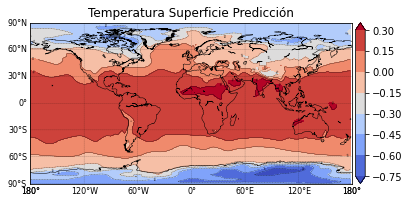

In [38]:
lat = np.arange(90,-92.5,-2.5)
lon = np.arange(0,360,2.5)


b = decoded_imgs[75].reshape(73, 144)


# make some plot 
#print('Ploting...')
#plt.figure() #setting the figure size

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)      
#This like sets the lat lon of the plot. Projection cylinder. 

map.drawcoastlines(linewidth=.5)  #draws coastline 

parallels = np.arange(-90,91,30.) # make latitude lines ever 30 degrees from 30N-50N
meridians = np.arange(-180,180,60.) # make longitude lines every 60 degrees from 95W to 70W

#labelling the lat and lon dimesion

map.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.2,fontsize=8)
map.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.2,fontsize=8)

b, lonout = shiftgrid(180, b, lon, start=False, cyclic=360.0)
lons,lats= np.meshgrid(lonout,lat) #2D lat lon to plot contours



x,y = map(lons,lats)


csf = map.contourf(x,y,b, extend='both',cmap='coolwarm') #filled contour
cb = map.colorbar(csf,"right", extend='both',size="3%", pad="1%")
cs = map.contour(x,y,b,colors='k',linewidths=0.3)


plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=3, colors='k')
plt.title('Temperatura Superficie Predicción')
plt.savefig("temp_superf_pred.png", dpi=200)
plt.show()

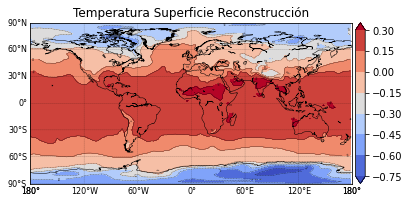

In [39]:
lat = np.arange(90,-92.5,-2.5)
lon = np.arange(0,360,2.5)


#b = decoded_imgs[0].reshape(73, 144)
b = suma[75].reshape(73, 144)

# make some plot 
#print('Ploting...')
#plt.figure() #setting the figure size

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180)      
#This like sets the lat lon of the plot. Projection cylinder. 

map.drawcoastlines(linewidth=.5)  #draws coastline 

parallels = np.arange(-90,91,30.) # make latitude lines ever 30 degrees from 30N-50N
meridians = np.arange(-180,180,60.) # make longitude lines every 60 degrees from 95W to 70W

#labelling the lat and lon dimesion

map.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.2,fontsize=8)
map.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.2,fontsize=8)

b, lonout = shiftgrid(180, b, lon, start=False, cyclic=360.0)
lons,lats= np.meshgrid(lonout,lat) #2D lat lon to plot contours



x,y = map(lons,lats)


csf = map.contourf(x,y,b, extend='both',cmap='coolwarm') #filled contour
cb = map.colorbar(csf,"right", extend='both',size="3%", pad="1%")
cs = map.contour(x,y,b,colors='k',linewidths=0.3)


plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=3, colors='k')
plt.title('Temperatura Superficie Reconstrucción')
plt.savefig("temp_superf_reconst.png", dpi=200)
plt.show()